<a href="https://colab.research.google.com/github/aleeshajaganath/Hackerearth-Challenges/blob/master/Dance_classification_using_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*gdrive*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd  gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
!ls

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.image as mpimg
import cv2
import os
import csv
import numpy as np
from PIL import Image
for file in fileList:
    #print(file)
   #
   try:
    imgfile = Image.open(file) # 
    #print(i)
    i=i+1#    imgfile.show()
    img = load_img(file, grayscale=False, target_size=(64, 64,3))
    
                  
    img = img_to_array(img)
                  
    #
    #img = img.reshape(64, 64,3)
    #150, 150, 3
                  
    img = img.astype('float32')
                  
    #
    img = img / 255.0
                  
    value = img.flatten()
                  
    with open("validation.csv", 'a') as f:
                      
        writer = csv.writer(f)
        writer.writerow(value)
      
   except OSError as e:
        print("last file is"+file)

Using TensorFlow backend.


**trainX.csv**

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.image as mpimg
import cv2
import os
import csv
import numpy as np
from PIL import Image
for file in fileList:
    #print(file)
   #
   try:
    imgfile = Image.open(file) # 
    #print(i)
    i=i+1#    imgfile.show()
    img = load_img(file, grayscale=False, target_size=(64, 64,3))
    
                  
    img = img_to_array(img)
                  
    #
    #img = img.reshape(64, 64,3)
    #150, 150, 3
                  
    img = img.astype('float32')
                  
    #
    img = img / 255.0
                  
    value = img.flatten()
                  
    with open("training_check.csv", 'a') as f:
                      
        writer = csv.writer(f)
        writer.writerow(value)
      
   except OSError as e:
        print("last file is"+file)

    
    
    

checking

RESNET50

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 19 00:21:40 2019

@author: user
"""
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
#%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X



def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides = (1,1),name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)conv_name_base + '1'
    X_shortcut=Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
   
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X



def ResNet50(input_shape = (64, 64, 3), classes = 224):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X =identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=4, block='b')
    X =identity_block(X, 3, [256,256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256, 1024], stage=4, block='d')
    X =identity_block(X, 3, [256,256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512,512, 2048], stage=5, block='b')
    X =identity_block(X, 3, [512,512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Using TensorFlow backend.


In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
!ls

In [ ]:
Y_train= pd.read_csv('trainY_1.csv',sep=',')
Y_train

# **Converting Multilabel to one hot vector**



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib import patches
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_df = pd.read_csv("validationY_copy.csv")
train_df.head()
a=[]
for i in range(len(train_df.id)):
        a.append(train_df.label[i].split(","))
        #print(mlb.classes_)
#        print( mlb.fit_transform(train_df.label[i]))
        
mlb.fit_transform(a)
print(mlb.classes_.shape)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from keras.utils import to_categorical

Y_test= pd.read_csv('ta1.csv',sep=',')
X_test= pd.read_csv('validationX1.csv',sep=',')
Y_train= pd.read_csv('ta.txt',sep=',')
X_train= pd.read_csv('trainX1.csv',sep=',')



#X_train, Y_train, X_test, Y_test_orig, classes = load_dataset()

#print(X_train_orig.shape)
# Normalize image vectors
#X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
#Y_train = to_categorical(Y_train_orig).reshape((1080, 6))
#Y_test = to_categorical(Y_test_orig).reshape((120, 6))

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 14719
number of test examples = 2999
X_train shape: (14719, 12288)
Y_train shape: (14718, 224)
X_test shape: (2999, 12288)
Y_test shape: (2999, 224)


In [ ]:
Y_train=Y_train.to_numpy()
Y_test=Y_test.to_numpy()

In [ ]:
import numpy as np
X_train=np.array(X_train[:][:])
Y_test=np.array(Y_test[:][:])
Y_train=np.array(Y_train[:][:])

In [ ]:

X_test=np.array(X_test[:][:])
Y_test=np.array(Y_test[:][:])
X_test=X_test.reshape([2999,64,64 ,3])
X_train=X_train.reshape([14718,64,64 ,3])

In [ ]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY= train_test_split(X_train,Y_train,test_size=0.20)


In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 224)

In [ ]:
#Ytest.shape
print(Y_test.shape,X_test.shape,Y_train.shape,X_train.shape)

(2999, 224) (2999, 64, 64, 3) (14718, 224) (14718, 64, 64, 3)


In [ ]:
X_test=X_test.reshape([2999,64,64 ,3])
X_train=X_train.reshape([14718,64,64 ,3])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train , Y_train , epochs = 2, batch_size = 32)

Epoch 1/2
14718/14718 [==============================] - 157s 11ms/step - loss: 0.1290 - acc: 0.9741
Epoch 2/2
14718/14718 [==============================] - 139s 9ms/step - loss: 0.1225 - acc: 0.9742


In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2999/2999 [==============================] - 6s 2ms/step
Loss = 0.11999377537246703
Test Accuracy = 0.9743396608421666


**Using pre trained model**

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 19 00:21:40 2019

@author: user
"""
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
#%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X



def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides = (1,1),name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)conv_name_base + '1'
    X_shortcut=Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
   
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X



def ResNet50(input_shape = (64, 64, 3), classes = 8):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X =identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=4, block='b')
    X =identity_block(X, 3, [256,256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256, 1024], stage=4, block='d')
    X =identity_block(X, 3, [256,256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512,512, 2048], stage=5, block='b')
    X =identity_block(X, 3, [512,512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model  

In [ ]:

Y_train=pd.read_csv("dance_trainY.csv")

X_train=pd.read_csv("dance_trainX.csv")
X_train.shape,Y_train['target'].shape

((363, 12288), (364,))

# splitted data

# dataset

In [ ]:
import pandas as pd
import numpy as np

# X_train=pd.read_csv("dance_training224.csv")
X_train=pd.read_csv("dance_trainX.csv")

X_train=np.array(X_train[:][:])
X_train=X_train.reshape([X_train.shape[0],64,64 ,3])
# importing one hot encoder 
# from sklearn
Y_train=pd.read_csv("dance_trainY.csv")

from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
Y_train = onehotencoder.fit_transform(Y_train['target'][:].values.reshape(-1,1)).toarray()
Y_train[0]


from sklearn.utils import shuffle
import numpy as np
# X = np.array([[1., 0.], [2., 1.], [0., 0.]])
# y = np.array([0, 1, 2])
# print(X_train,Y_train)
X_train,Y_train = shuffle(X_train,Y_train, random_state=0)
# X,y 

# Y_train=pd.read_csv("dance_trainingY.csv")
# X_train[:492].shape,Y_train[:492].shape
#.head()

from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY= train_test_split(X_train,Y_train,test_size=0.20)


In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model = ResNet50(input_shape = (64, 64, 3), classes = 8)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print

In [ ]:
# history=model.fit(trainX , trainY , epochs = 2, batch_size = 32)
# from sklearn.datasets import make_blobs
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.optimizers import SGD
# from keras.utils import to_categorical
# from matplotlib import pyplot
# # evaluate the model
# _, train_acc = model.evaluate(trainX, trainY, verbose=0)
# _, test_acc = model.evaluate(testX, testY, verbose=0)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# # plot loss during training
# pyplot.subplot(211)
# pyplot.title('Loss')
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# # plot accuracy during training
# pyplot.subplot(212)
# pyplot.title('Accuracy')
# pyplot.plot(history.history['accuracy'], label='train')
# pyplot.plot(history.history['val_accuracy'], label='test')
# pyplot.legend()
# pyplot.show()

# train

In [ ]:
# model = ResNet50(input_shape = (64, 64, 3), classes = 8)
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(trainX , trainY , epochs = 15, batch_size = 32)

In [ ]:
trainX.shape , trainY.shape

((290, 224, 224, 3), (290, 8))

In [ ]:
preds = model.evaluate(testX, testY)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

99/99 [==============================] - 1s 6ms/step
Loss = 5.449335195801475
Test Accuracy = 0.27272728085517883


In [ ]:
# fit model
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=15, verbose=0)



# dance_training224

In [ ]:
import os
path="train/"
fileList=os.listdir("train/")
# path="/media/aleeshasj/Os/Challenges/dance/dataset/test/"
# fileList=os.listdir("/media/aleeshasj/Os/Challenges/dance/dataset/test/")

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.image as mpimg
import cv2
import os
import csv
import numpy as np
from PIL import Image
# df=pd.read_csv("dataset/trainY.csv")
for file in fileList:
   


   #
   try:
    imgfile = Image.open(path+file)
    
    
    # 
#     print(df[df['Image']==file]['target'].tolist()[0])
#     i=i+1#    imgfile.show()
    img = load_img(path+file, grayscale=False, target_size=(512, 512,3))
#     print(file)
                  
    img = img_to_array(img)
                  
    #
    #img = img.reshape(64, 64,3)
    #150, 150, 3
                  
    img = img.astype('float32')
                  
    #
    img = img / 255.0
                  
    value = img.flatten()
                  
#     with open("dance_testing.csv", 'a') as f:
    with open("dance_training512.csv", 'a') as f:
                      
        writer = csv.writer(f)
        writer.writerow(value)
      
   except OSError as e:
        print("last file is"+file)

    
    
    

# balancing

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd  gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
!ls

Using TensorFlow backend.


New Data Size: 1032 Old Size: 857


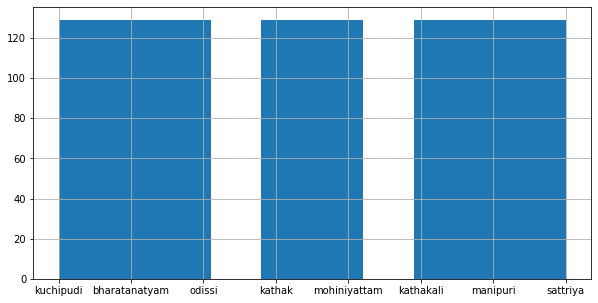

In [ ]:


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.image as mpimg
import cv2
import os
import csv
import pandas as pd

import numpy as np
from PIL import Image

"balancing using the replacement method"

def balance_data(class_size,df):
    train_df = df.groupby(['target']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['target'].hist(figsize = (10, 5))
    return train_df

"""combining 2 dataframes"""
df_train1=pd.read_csv("train.csv")

df_train2=pd.read_csv("dance_trainingY.csv")
d=[df_train1,df_train2]
df_train=pd.concat(d)
from sklearn.utils import shuffle
# df_train = shuffle(df_train)

# df_train=pd.read_csv("train.csv")

df_train = balance_data(int(df_train.pivot_table(index='target', aggfunc=len).max().max()),df_train) # I will oversample such that all classes have the same number of images as the maximum
# df_train['target'].hist(figsize = (12, 12))


# fit

In [ ]:

from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

# Y_train=pd.read_csv("dance_trainY.csv")
# image=os.listdir("train/")
# image=Y_train['Image'].tolist()
image=df_train['Image'].tolist()
import csv
import pandas as pd

writer1=[]
   
for i in range(len(image)):

           try:
                    # imgfile = Image.open("seperated_train/"+image[i]) 
                   
                    img = load_img("seperated_train/"+image[i], grayscale=False, target_size=(512,512,3))

                    # img = load_img("train/"+image[i], grayscale=False, target_size=(512,512,3))

                    img = img_to_array(img)


                    img = img.astype('float32')


                    img = img / 255.0

                    value = img.flatten()
                    writer1.append(value)

                   
           except OSError as e:

                   print("last file is"+file)

In [ ]:
len(writer1),writer1[0].shape

(1032, (786432,))

In [ ]:
import pandas as pd
import numpy as np

# X_train=pd.read_csv("dance_training224.csv")
# X_train=pd.read_csv("dance_trainX.csv")
X_train=np.array(writer1[:][:])
# X_train=np.array(X_train[:][:])
X_train=X_train.reshape([X_train.shape[0],512,512 ,3])
# importing one hot encoder 
# from sklearn
Y_train=pd.read_csv("dance_trainY.csv")

from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 



from sklearn.utils import shuffle
import numpy as np
# X = np.array([[1., 0.], [2., 1.], [0., 0.]])
# y = np.array([0, 1, 2])
# print(X_train,Y_train)
X_train,Y_train = shuffle(X_train,df_train, random_state=0)
Y_train = onehotencoder.fit_transform(Y_train['target'][:].values.reshape(-1,1)).toarray()
Y_train[0]
# X,y 

# Y_train=pd.read_csv("dance_trainingY.csv")
# X_train[:492].shape,Y_train[:492].shape
#.head()

from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY= train_test_split(X_train,Y_train,test_size=0.20)


# *VGG16 Training*

In [ ]:
import tensorflow as tf

# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from keras.models import load_model

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape = (512, 512, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
# base_model.summary()
prediction_layer = tf.keras.layers.Dense(8, activation="softmax")
VGG16_model = tf.keras.Sequential([
  base_model,
  # tf.keras.layers.Dense(64, activation="relu"),
  # tf.keras.layers.Dense(256, activation="relu"),
  # tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(1024, activation="relu"),
  
  # tf.keras.layers.MaxPooling2D( pool_size=(2, 2), strides=None, padding='valid',input_shape=(4,4,1)),
  # tf.keras.layers.MaxPooling2D(2),
  
  tf.keras.layers.Dense(512, activation="relu"),
  
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),# tf.keras.layers.Dropout(0.5),
  prediction_layer
])
# trainY=np.argmax(trainY,axis=1)


"""balance the dataset"""
VGG16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# VGG16_model.summary()
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_for_dance_Dropout.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
# history = VGG16_model.fit(trainX,trainY , validation_data=(testX, testY), epochs=100, verbose=0, callbacks=[es, mc])
# load the saved model


VGG16_model.fit(X_train,Y_train , epochs = 50, batch_size = 16)

Epoch 1/50
65/65 [==============================] - 14s 210ms/step - loss: 2.0686 - accuracy: 0.1696
Epoch 2/50
65/65 [==============================] - 13s 199ms/step - loss: 1.8522 - accuracy: 0.2461
Epoch 3/50
65/65 [==============================] - 13s 199ms/step - loss: 1.7324 - accuracy: 0.3014
Epoch 4/50
65/65 [==============================] - 13s 198ms/step - loss: 1.5762 - accuracy: 0.3760
Epoch 5/50
65/65 [==============================] - 13s 199ms/step - loss: 1.5192 - accuracy: 0.4118
Epoch 6/50
65/65 [==============================] - 13s 198ms/step - loss: 1.4014 - accuracy: 0.4700
Epoch 7/50
65/65 [==============================] - 13s 199ms/step - loss: 1.3155 - accuracy: 0.5058
Epoch 8/50
65/65 [==============================] - 13s 198ms/step - loss: 1.1832 - accuracy: 0.5436
Epoch 9/50
65/65 [==============================] - 13s 198ms/step - loss: 1.0957 - accuracy: 0.5901
Epoch 10/50
65/65 [==============================] - 13s 198ms/step - loss: 1.0137 - accura

In [ ]:
VGG16_model.save('VGG16_model.h5')

In [ ]:
!ls

In [ ]:
y=le.transform(Y_train['target'])
Y=Y_train['target'].tolist()
y_one=onehotencoder.fit_transform(y[:364].reshape(-1,1)).toarray()
# for i in range(20):#len(y_one)):
#     print(y_one[i],y[i],Y[i],le.inverse_transform([y[i]])) 

In [ ]:
# importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
best_model_for_dance

In [ ]:
# #Making prediction
# Y_pred=VGG16_model.predict_classes(testX)
# Y_true=np.argmax(testX,axis=1)

In [ ]:
#Making prediction
y_pred=VGG16_model.predict_classes(testX)
y_true=np.argmax(testY,axis=1)


(493, 2)

# test

In [ ]:
import pandas as pd 
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
test=pd.read_csv("test.csv")

# image=os.listdir("train/")
image=test['Image'].tolist()
import csv
import pandas as pd

writer=[]
   
for i in range(len(image)):

           try:
                    imgfile = Image.open("test/"+image[i]) 
                   
                    img = load_img("test/"+image[i], grayscale=False, target_size=(512,512,3))


                    img = img_to_array(img)


                    img = img.astype('float32')


                    img = img / 255.0

                    value = img.flatten()
                    writer.append(value)

                   
           except OSError as e:

                   print("last file is"+file)

Using TensorFlow backend.


In [ ]:
!ls

In [ ]:
import pandas as pd
import numpy as np

# X_train=pd.read_csv("dance_training224.csv")
# X_train=pd.read_csv("dance_trainX.csv")
X_train=np.array(writer[:][:])
# X_train=np.array(X_train[:][:])
X_train=X_train.reshape([X_train.shape[0],512,512 ,3])
# importing one hot encoder 
# from sklearn
# test=pd.read_csv("test.csv")
# Y_train=pd.read_csv("test.csv")

# from sklearn.preprocessing import OneHotEncoder
# # creating one hot encoder object 
# onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
# Y_train = onehotencoder.fit_transform(Y_train['target'][:364].values.reshape(-1,1)).toarray()
# Y_train[0]


# Y_train,np.argmax(Y_train,axis=1)
Y_train=pd.read_csv("dance_trainY.csv")
Y_train['target']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train['target'])
le.classes_

array(['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri',
       'mohiniyattam', 'odissi', 'sattriya'], dtype=object)

In [ ]:
y=le.transform(Y_train['target'])
le.transform(Y_train['target'])

In [ ]:

from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras.models import load_model
saved_model = load_model('VGG16_model.h5')




In [ ]:

y=VGG16_model.predict_classes(X_train)
y1=le.inverse_transform(y)
for i in range(len(y)):
    print(y[i],y1[i]) 

In [ ]:
le.inverse_transform(y)

In [ ]:
import csv
y=saved_model.predict_classes(X_train)

y=le.inverse_transform(y)
with open('employee_file21.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    employee_writer.writerow(['Image', 'target'])
    for i in range(len(y)):
        employee_writer.writerow([image[i], y[i]])


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
pd.read_csv('employee_file5.csv')['target']

In [ ]:
# Y_train,np.argmax(Y_train,axis=1)
Y_train=pd.read_csv("dance_trainY.csv")
Y_train['target']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train['target'])
le.classes_

array(['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri',
       'mohiniyattam', 'odissi', 'sattriya'], dtype=object)

# Early Stopping

Train: 1.000, Test: 0.914


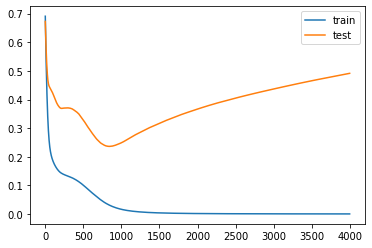

In [ ]:
# mlp overfit on the moons dataset
from sklearn.datasets import make_moons
from keras.layers import Dense
from keras.models import Sequential
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# split into train and test
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 00215: early stopping
Train: 0.967, Test: 0.814


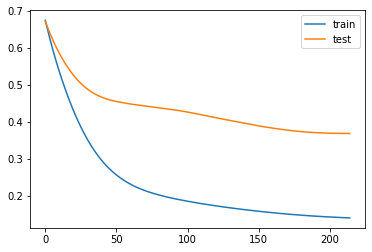

In [ ]:
# mlp overfit on the moons dataset with simple early stopping
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# split into train and test
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 00990: early stopping
Train: 1.000, Test: 0.943


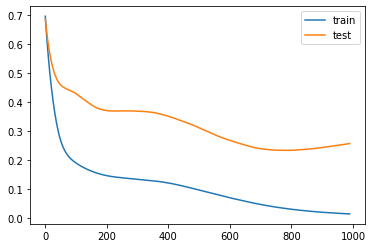

In [ ]:
# mlp overfit on the moons dataset with patient early stopping
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# split into train and test
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from keras.models import load_model
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# split into train and test
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es, mc])
# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Epoch 00001: val_accuracy improved from -inf to 0.72857, saving model to best_model.h5

Epoch 00002: val_accuracy did not improve from 0.72857

Epoch 00003: val_accuracy did not improve from 0.72857

Epoch 00004: val_accuracy did not improve from 0.72857

Epoch 00005: val_accuracy did not improve from 0.72857

Epoch 00006: val_accuracy did not improve from 0.72857

Epoch 00007: val_accuracy did not improve from 0.72857

Epoch 00008: val_accuracy did not improve from 0.72857

Epoch 00009: val_accuracy did not improve from 0.72857

Epoch 00010: val_accuracy did not improve from 0.72857

Epoch 00011: val_accuracy did not improve from 0.72857

Epoch 00012: val_accuracy did not improve from 0.72857

Epoch 00013: val_accuracy did not improve from 0.72857

Epoch 00014: val_accuracy did not improve from 0.72857

Epoch 00015: val_accuracy did not improve from 0.72857

Epoch 00016: val_accuracy did not improve from 0.72857

Epoch 00017: val_accuracy did not improve from 0.72857

Epoch 00018: va

# ResNet50 Pre-trained Model


New Data Size: 1032 Old Size: 857


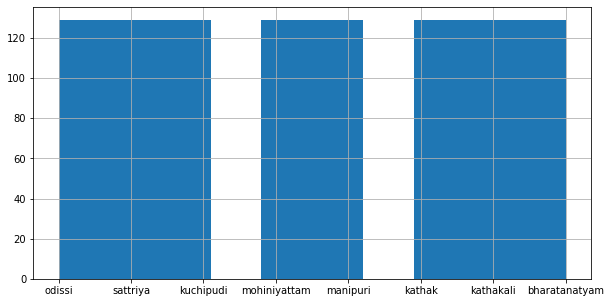

In [ ]:


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.image as mpimg
import cv2
import os
import csv
import pandas as pd

import numpy as np
from PIL import Image

"balancing using the replacement method"

def balance_data(class_size,df):
    train_df = df.groupby(['target']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['target'].hist(figsize = (10, 5))
    return train_df

"""combining 2 dataframes"""
df_train1=pd.read_csv("train.csv")

df_train2=pd.read_csv("dance_trainingY.csv")
d=[df_train1,df_train2]
df_train=pd.concat(d)
# df_train=pd.read_csv("train.csv")

df_train = balance_data(int(df_train.pivot_table(index='target', aggfunc=len).max().max()),df_train) # I will oversample such that all classes have the same number of images as the maximum
# df_train['target'].hist(figsize = (12, 12))


In [ ]:
!ls

In [ ]:

from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

# Y_train=pd.read_csv("dance_trainY.csv")
# image=os.listdir("train/")
# image=Y_train['Image'].tolist()
image=df_train['Image'].tolist()
import csv
import pandas as pd

writer=[]
   
for i in range(len(image)):

           try:
                    # imgfile = Image.open("seperated_train/"+image[i]) 
                   
                    # img = load_img("seperated_train/"+image[i], grayscale=False, target_size=(512,512,3))

                    img = load_img("seperated_train/"+image[i], grayscale=False, target_size=(224,224,3))

                    img = img_to_array(img)


                    img = img.astype('float32')


                    img = img / 255.0

                    value = img.flatten()
                    writer.append(value)

                   
           except OSError as e:

                  #  print("last file is"+file)
                  img = load_img("train/"+image[i], grayscale=False, target_size=(224,224,3))

                  plt.imshow(img)

In [ ]:
import pandas as pd
import numpy as np

# X_train=pd.read_csv("dance_training224.csv")
# X_train=pd.read_csv("dance_trainX.csv")
X_train=np.array(writer[:][:])
# X_train=np.array(X_train[:][:])
X_train=X_train.reshape([X_train.shape[0],224,224 ,3])
# importing one hot encoder 
# from sklearn
Y_train=pd.read_csv("dance_trainY.csv")

from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 



from sklearn.utils import shuffle
import numpy as np
# X = np.array([[1., 0.], [2., 1.], [0., 0.]])
# y = np.array([0, 1, 2])
# print(X_train,Y_train)
X_train,Y_train = shuffle(X_train,df_train, random_state=0)
Y_train = onehotencoder.fit_transform(Y_train['target'][:].values.reshape(-1,1)).toarray()
Y_train[0]
# X,y 

# Y_train=pd.read_csv("dance_trainingY.csv")
# X_train[:492].shape,Y_train[:492].shape
#.head()

from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY= train_test_split(X_train,Y_train,test_size=0.20)

from keras.applications.resnet50 import ResNet50
# load model
model = ResNet50()
# summarize the model
# model.summary()




model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# mc = ModelCheckpoint('best_model_for_dance1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
# history = VGG16_model.fit(trainX,trainY , validation_data=(testX, testY), epochs=100, verbose=0, callbacks=[es, mc])
# load th
model.fit(trainX,trainY , validation_data=(testX, testY) , epochs = 50, batch_size = 16)
# history = model.fit(trainX,trainY , validation_data=(testX, testY), epochs=100]#, verbose=0, callbacks=[es, mc])


In [ ]:
import tensorflow as tf

# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from keras.models import load_model

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50(
                                               include_top=False,
                                              )
# base_model.trainable = False
# base_model.summary()
prediction_layer = tf.keras.layers.Dense(8, activation="softmax")
ResNet50_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  prediction_layer
])
# trainY=np.argmax(trainY,axis=1)

# softmax
"""balance the dataset"""
ResNet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# mc = ModelCheckpoint('best_model_for_dance1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# # fit model
# history = ResNet50_model.fit(trainX,trainY , validation_data=(testX, testY), epochs=100, verbose=0, callbacks=[es, mc])
# load the saved model


ResNet50_model.fit(X_train,Y_train , epochs = 50, batch_size = 16)

Epoch 1/50
65/65 [==============================] - 6s 100ms/step - loss: 2.1311 - accuracy: 0.2626
Epoch 2/50
65/65 [==============================] - 6s 100ms/step - loss: 1.8433 - accuracy: 0.3169
Epoch 3/50
65/65 [==============================] - 6s 100ms/step - loss: 1.6316 - accuracy: 0.4021
Epoch 4/50
65/65 [==============================] - 6s 100ms/step - loss: 1.4300 - accuracy: 0.4690
Epoch 5/50
65/65 [==============================] - 6s 100ms/step - loss: 1.2354 - accuracy: 0.5678
Epoch 6/50
65/65 [==============================] - 6s 100ms/step - loss: 1.0104 - accuracy: 0.6347
Epoch 7/50
65/65 [==============================] - 6s 100ms/step - loss: 0.8350 - accuracy: 0.7103
Epoch 8/50
65/65 [==============================] - 6s 100ms/step - loss: 0.6846 - accuracy: 0.7694
Epoch 9/50
65/65 [==============================] - 6s 100ms/step - loss: 0.5950 - accuracy: 0.8043
Epoch 10/50
65/65 [==============================] - 6s 100ms/step - loss: 0.4941 - accuracy: 0.8372

## Test

In [ ]:
import pandas as pd 
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
test=pd.read_csv("test.csv")

# image=os.listdir("train/")
image=test['Image'].tolist()
import csv
import pandas as pd

writer=[]
   
for i in range(len(image)):

           try:
                    imgfile = Image.open("test/"+image[i]) 
                   
                    img = load_img("test/"+image[i], grayscale=False, target_size=(224,224,3))


                    img = img_to_array(img)


                    img = img.astype('float32')


                    img = img / 255.0

                    value = img.flatten()
                    writer.append(value)

                   
           except OSError as e:

                   print("last file is"+file)

In [ ]:
import pandas as pd
import numpy as np

# X_train=pd.read_csv("dance_training224.csv")
# X_train=pd.read_csv("dance_trainX.csv")
X_train=np.array(writer[:][:])
# X_train=np.array(X_train[:][:])
X_train=X_train.reshape([X_train.shape[0],224,224 ,3])
# importing one hot encoder 
# from sklearn
# test=pd.read_csv("test.csv")
# Y_train=pd.read_csv("test.csv")

# from sklearn.preprocessing import OneHotEncoder
# # creating one hot encoder object 
# onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
# Y_train = onehotencoder.fit_transform(Y_train['target'][:364].values.reshape(-1,1)).toarray()
# Y_train[0]


# Y_train,np.argmax(Y_train,axis=1)
Y_train=pd.read_csv("dance_trainY.csv")
Y_train['target']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train['target'])
le.classes_


import csv
y=ResNet50_model.predict_classes(X_train)

y=le.inverse_transform(y)
with open('employee_file10.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    employee_writer.writerow(['Image', 'target'])
    for i in range(len(y)):
        employee_writer.writerow([image[i], y[i]])


# MobileNetV2

In [ ]:

# Create the base model from the pre-trained model MobileNet V2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from matplotlib import pyplot
from keras.models import load_model
from keras.layers import Dense,GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY= train_test_split(X_train,Y_train,test_size=0.20)


base_model = tf.keras.applications.MobileNetV2(input_shape = (512, 512, 3),
                                               include_top=False,
                                               weights='imagenet')


base_model.trainable = False
base_model.summary()
prediction_layer = tf.keras.layers.Dense(8, activation="softmax")
# mobile_model = tf.keras.Sequential([
#   base_model,
#   # global_average_layer,
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(1024, activation="relu"),
#   tf.keras.layers.Dense(512, activation="relu"),
#   # tf.keras.layers.Dropout(0.5),
#   prediction_layer
# ])

mobile_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(512, activation="relu"),
  # tf.keras.layers.Dropout(0.5),
  prediction_layer
])


"""balance the dataset"""
mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# mobile_model.summary()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_mobile_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = mobile_model.fit(trainX,trainY , validation_data=(testX, testY), epochs=100, verbose=0, callbacks=[es, mc])



# mobile_model.fit(X_train,Y_train , epochs = 50, batch_size = 16)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
!ls

## Test

In [ ]:

from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras.models import load_model
# mobile_model = load_model('best_model_mobile_model.h5')




In [ ]:
import csv
y=mobile_model.predict_classes(X_train)

y=le.inverse_transform(y)
with open('employee_file16.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    employee_writer.writerow(['Image', 'target'])
    for i in range(len(y)):
        employee_writer.writerow([image[i], y[i]])
